<a href="https://colab.research.google.com/github/nataliiakrasilynets/Sales-Analytics/blob/main/Portfolio_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Підключення до бібліотек, Google disk та google bigquery

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import auth
import seaborn as sns
auth.authenticate_user()
from google.cloud import bigquery
project_id = 'data-analytics-mate'
client = bigquery.Client(project=project_id)

#2. вивантаження даних з google bigquery

In [ ]:
#2. вивантаження даних з google bigquery
query = """
  SELECT
    ses.date,
    ses.ga_session_id,
    continent,
    country,
    device,
    mobile_model_name,
    operating_system,
    browser,
    language,
    medium,
    channel,
    acc.id, is_verified, is_unsubscribed, category, pr.name, price, short_description
  FROM
    `data-analytics-mate.DA.session` ses
  LEFT JOIN
    `data-analytics-mate.DA.session_params` sp
  ON
    ses.ga_session_id = sp.ga_session_id
  LEFT JOIN
    `data-analytics-mate.DA.order` ord
  ON
    ses.ga_session_id = ord.ga_session_id
  LEFT JOIN
    `data-analytics-mate.DA.product` pr
  ON
    ord.item_id = pr.item_id
  LEFT JOIN
    `data-analytics-mate.DA.account_session` ass
  ON
    ord.ga_session_id = ass.ga_session_id
  LEFT JOIN
    `data-analytics-mate.DA.account` acc
  ON
    ass.account_id = acc.id
"""

In [ ]:
query_job = client.query(query)
rows = query_job.result()
df = rows.to_dataframe()

#3. Інформація по створеному dataframe


1. загальна кількість колонок: 18
2. кількість колонок числового типу (та які саме): 3 (ga_session_id, id, price)
3. кількість колонок категоріального типу (та які саме): 14 (continent, country, device, mobile_model_name, operating_system, browser, language, medium, channel,category, name, short_description, is_verified, is_unsubscribed, )
4. кількість колонок типу datetime: 1
5. кількість унікальних сесій: 349545
6. який період часу розглядається від 01.11.2020 до 31.01.2021
7. чи є пропущені значення: так
8. в яких колонках більше пропущених значень, яка причина?: в колонках пов'язаних з інформацією про акаунти так як не всі сесії відбувались за зареєстрованими акаунтами
9. ще пропущені дані містяться в колонках пов'заних з інформацією про товари, так як не по всіх сесіях здійснювались замовлення

In [ ]:
x = df["ga_session_id"].unique().shape
y = df["date"].min()
z = df["date"].max()
print(x, y, z)

(349545,) 2020-11-01 2021-01-31


In [ ]:
df['is_unsubscribed'] = df['is_unsubscribed'].astype(str)
df['is_verified'] = df['is_verified'].astype(str)
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
df['date'] = pd.to_datetime(df['date'])

#4

##Топ-3 континенти за к-стю продажей

In [ ]:
top_continent_sales = df.groupby("continent")["price"].sum().reset_index().sort_values(by="price",ascending=False).head(3)
top_country_sales = df.groupby("country")["price"].sum().reset_index().sort_values(by="price", ascending=False).head(5)
top_country_sold = df.groupby("country")["id"].count().sort_values(ascending=False).head(5)
top_continent_sold = df.groupby("continent")["id"].count().sort_values(ascending=False).head(3)

In [ ]:
top_continent_sales

,continent,price
2,Americas,17665280.0
3,Asia,7601298.3
4,Europe,5934624.2


##Топ-5 країн за к-стю продажей

In [ ]:
top_country_sales

,country,price
104,United States,13943553.9
43,India,2809762.0
18,Canada,2437921.0
103,United Kingdom,938317.9
33,France,710692.8


##Топ-3 континенти за к-стю проданих одиниць

In [ ]:
top_country_sold

,id
country,
United States,1207
India,246
Canada,207
United Kingdom,88
Germany,56


##Топ-5 країн за к-стю проданих одиниць

In [ ]:
top_continent_sold

,id
continent,
Americas,1532
Asia,664
Europe,523


##Топ-10 категорій товарів за загальною сумою продажів

In [ ]:
top_category_sales = df.groupby("category")["price"].sum().reset_index().sort_values(ascending=False, by="price").head(10)
top_category_sales

,category,price
12,Sofas & armchairs,8388254.5
5,Chairs,6147748.8
1,Beds,4919725.0
2,Bookcases & shelving units,3640818.1
3,Cabinets & cupboards,2336499.5
9,Outdoor furniture,2142222.2
13,Tables & desks,1790307.5
6,Chests of drawers & drawer units,906562.5
0,Bar furniture,735503.0
7,Children's furniture,467697.0


##Топ-10 категорій товарів у розрізі країн за сумою продажів
результат майже не змінився (7 із 10 категорій знову попали в топ)

In [ ]:
top_category_sales_country = df.groupby(["country", "category"])["price"].sum().sort_values(ascending=False).head(10)
top_category_sales_country

country        category                  
United States  Sofas & armchairs             3707144.5
               Chairs                        2619773.8
               Beds                          2213058.0
               Bookcases & shelving units    1567606.9
               Cabinets & cupboards           994545.5
               Outdoor furniture              929245.2
India          Sofas & armchairs              788430.0
United States  Tables & desks                 777865.0
Canada         Sofas & armchairs              692427.5
India          Chairs                         544309.2
Name: price, dtype: float64

##Продажі у розрізі типів та моделей девайсів

In [ ]:
sales_typ_model = df.groupby(["device", "mobile_model_name"])["price"].sum() / df["price"].sum() * 100
sales_typ_model

device   mobile_model_name
desktop  <Other>               1.644093
         Chrome               27.835602
         ChromeBook            5.725241
         Edge                  2.179667
         Firefox               1.316998
         Safari               20.300643
mobile   <Other>              17.937951
         Edge                  0.001079
         Pixel 3               0.341390
         Pixel 4 XL            0.369976
         Safari                0.001861
         iPhone               20.082667
tablet   <Other>               0.858922
         iPad                  1.403910
Name: price, dtype: float64

##Продажі за джерелами трафіку

In [ ]:
sales_medium = df.groupby("medium")["price"].sum() / df["price"].sum() * 100
sales_medium

,price
medium,
(data deleted),6.386645
(none),23.442345
<Other>,14.047882
cpc,4.273902
organic,34.202840
referral,17.646386


##Відсоток зареєстрованих користувачів підтвердив свою електронну адресу, відписався від розсилки

In [ ]:
sales_is_verified = df[df["is_verified"] == "1"]["id"].count() / df["id"].count() * 100
print (f"{sales_is_verified} % зареєстрованих користувачів підтвердили свою електронну адресу")
sales_is_unsubscribed = df[df["is_unsubscribed"] == "1"]["id"].count() / df["id"].count() * 100
print (f"{sales_is_unsubscribed} % зареєстрованих користувачів відписалися від розсилки")

71.52103559870551 % зареєстрованих користувачів підтвердили свою електронну адресу
16.073354908306364 % зареєстрованих користувачів відписалися від розсилки


##Чи відрізняється поведінка (у плані продажів) тих, хто відписався від розсилки та тих, хто досі підписаний?
Як можемо почати ті, що відписались здійснюють більше продажів та купують більше товару

In [ ]:
is_unsubscribed_sales= df.groupby("is_unsubscribed")["price"].sum().reset_index()
is_unsubscribed_0_or_1 = is_unsubscribed_sales[(is_unsubscribed_sales["is_unsubscribed"] == "0") | (is_unsubscribed_sales["is_unsubscribed"] == "1")]

In [ ]:
price_not_null_sum = df[df['id'].notnull()]['price'].sum()
#відсоток продажів по зареєстрованих користувачах
is_unsubscribed_sales_of_total= df.groupby("is_unsubscribed")["price"].sum() / price_not_null_sum * 100
is_unsubscribed_sales_of_total

,price
is_unsubscribed,
0,83.282923
1,16.717077
<NA>,1138.005888


In [ ]:
#відсоток продажів по зареєстрованих користувачах від загальних продаж
is_unsubscribed_sales_of_total= df[df["id"].notnull()].groupby("is_unsubscribed")["price"].sum() / df["price"].sum() * 100
is_unsubscribed_sales_of_total

,price
is_unsubscribed,
0,6.727183
1,1.350323


In [ ]:
#відписаних користувачів
is_unsubscribed_sold= df[df["id"].notnull()].groupby("is_unsubscribed")["id"].count()
is_unsubscribed_sold

,id
is_unsubscribed,
0,2334
1,447


In [ ]:
#відсоток відписаних користувачів
is_unsubscribed_sold_of_total= df[df["id"].notnull()].groupby("is_unsubscribed")["id"].count() / df["id"].count() * 100
is_unsubscribed_sold_of_total

,id
is_unsubscribed,
0,83.926645
1,16.073355


##В яких країнах найбільше зареєстрованих користувачів?

In [ ]:
country_id = df.groupby("country")["id"].count().sort_values(ascending=False)
country_id

,id
country,
United States,1207
India,246
Canada,207
United Kingdom,88
Germany,56
...,...
Mongolia,0
Qatar,0
Puerto Rico,0


##у розрізі каналів

In [ ]:
sales_channel = df.groupby("channel")["price"].sum().reset_index()
sales_channel

,channel,price
0,Direct,7494923.4
1,Organic Search,11433151.6
2,Paid Search,8511049.4
3,Social Search,2532105.7
4,Undefined,2000501.0


In [ ]:
sold_channel = df.groupby("channel")["id"].count()
sold_channel

,id
channel,
Direct,636
Organic Search,1016
Paid Search,706
Social Search,238
Undefined,185


##Обчислення пов'язані з датою

In [ ]:
date_sales = df.groupby('date')['price'].sum().reset_index()
sales_date_of_continent = df.groupby(['date', 'continent'])['price'].sum().reset_index()
sales_date_continent_choose = sales_date_of_continent[sales_date_of_continent['continent'].isin(['Americas', 'Europe', 'Asia'])]
sales_data_channel = df.groupby(['date', 'channel'])['price'].sum().reset_index()
sales_data_device = df.groupby(['date', 'device'])['price'].sum().reset_index()
sales_date_category = df.groupby(['date', 'category'])['price'].sum().reset_index()

##Візуалізації

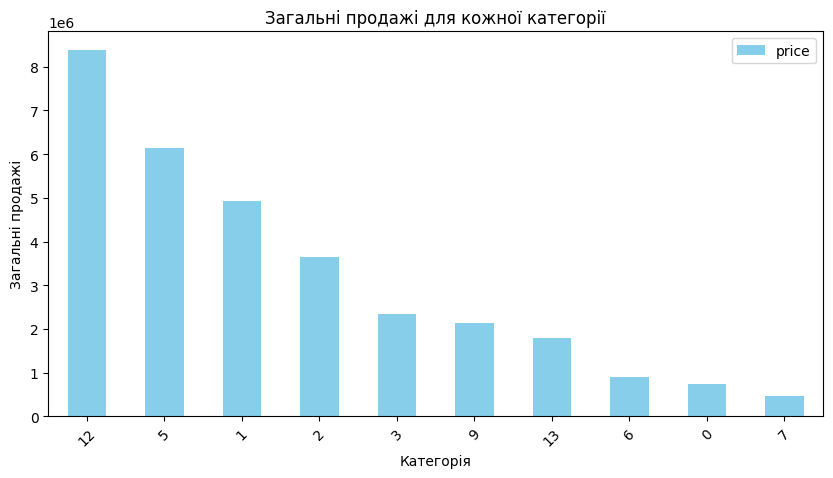

In [ ]:
plt.figure(figsize=(10, 5))
top_category_sales.plot(kind='bar', color='skyblue', ax=plt.gca())
plt.title('Загальні продажі для кожної категорії')
plt.xlabel('Категорія')
plt.ylabel('Загальні продажі')
plt.xticks(rotation=45)
plt.show()

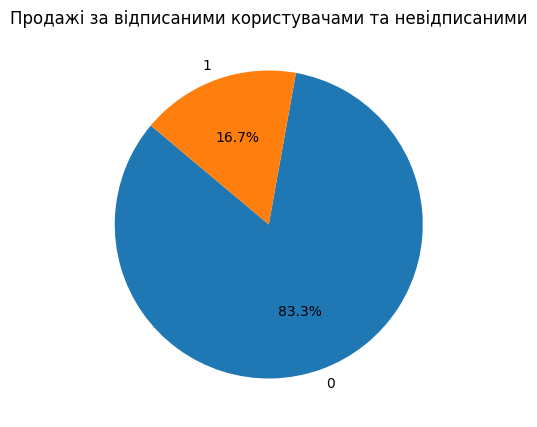

In [ ]:
plt.figure(figsize=(10, 5))
plt.pie(is_unsubscribed_0_or_1['price'], labels=is_unsubscribed_0_or_1['is_unsubscribed'], autopct='%1.1f%%', startangle=140)
plt.title("Продажі за відписаними користувачами та невідписаними")
plt.show()

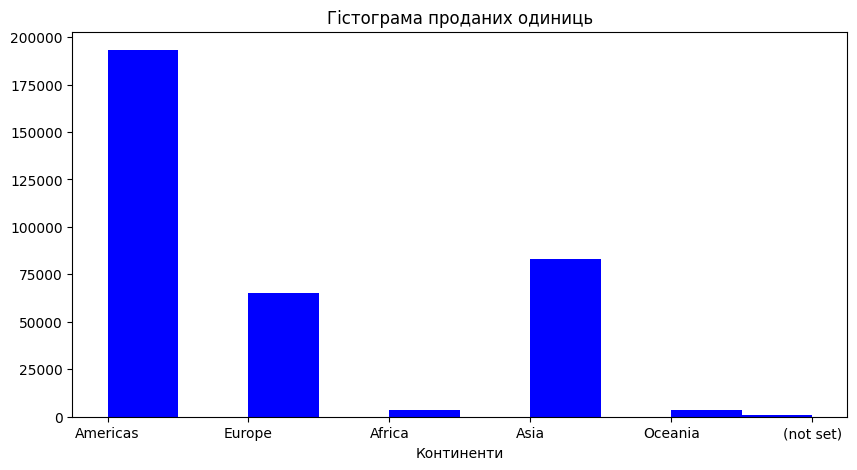

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(df['continent'], bins=10, color='blue')
plt.title('Гістограма проданих одиниць')
plt.xlabel('Континенти')
plt.show()

#5

##Динаміка загальних продажей

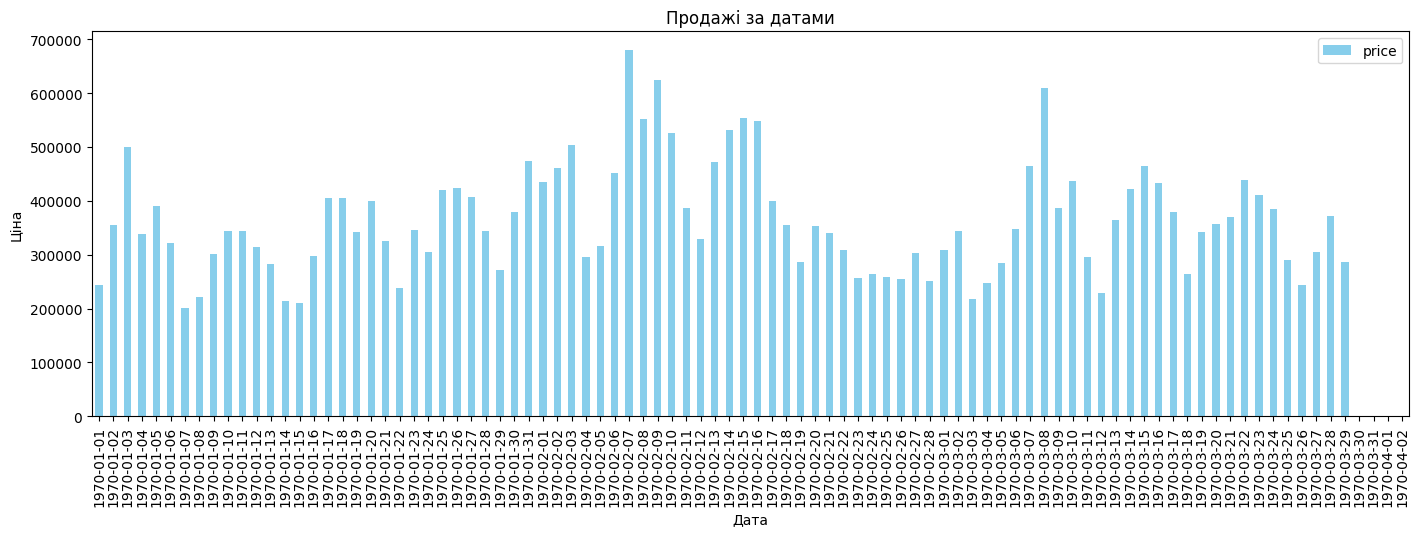

In [ ]:
import matplotlib.dates as mdates
# Встановлюємо формат відображення дат на осі X
fig, ax = plt.subplots(figsize=(17, 5))
date_sales.plot(kind='bar', x='date', y='price', color='skyblue', ax=ax)
ax.set_title('Продажі за датами')
ax.set_xlabel('Дата')
ax.set_ylabel('Ціна')

# Форматування міток осі X
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=90)
plt.show()

Так, сезонність зберігається

##Динаміка продажей за континентом

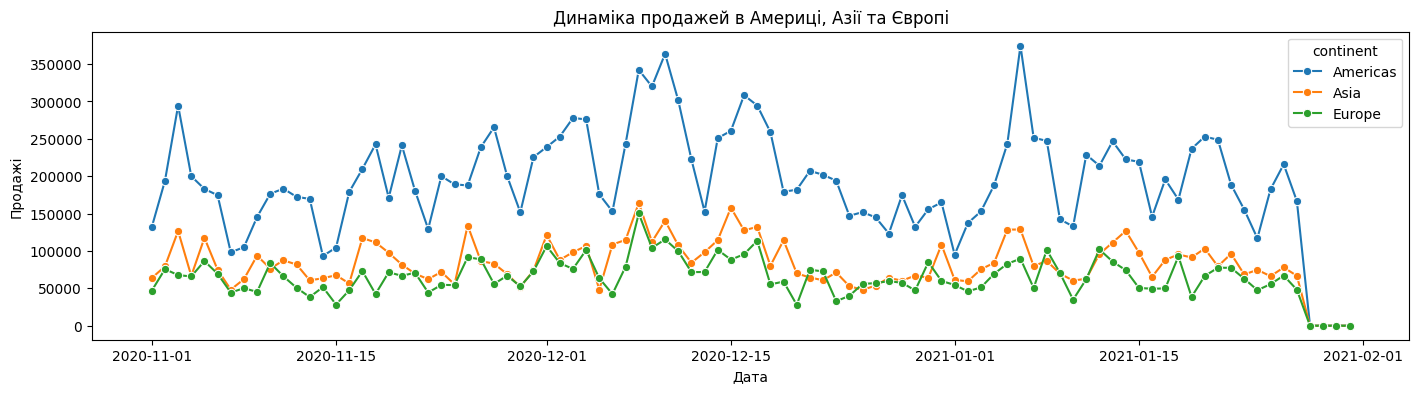

In [ ]:
plt.figure(figsize=(17, 4))
sns.lineplot(data=sales_date_continent_choose, x='date', y='price', hue='continent', marker='o')
plt.title('Динаміка продажей в Америці, Азії та Європі')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.show()

Як зображено на графіку найбільші продажі відбуваються з континету Америка (на початку кожного місяця підвищення продажей), Азія та Європа (для цих двох континентів зберігається циклічність)

##Динаміка продажей за каналом

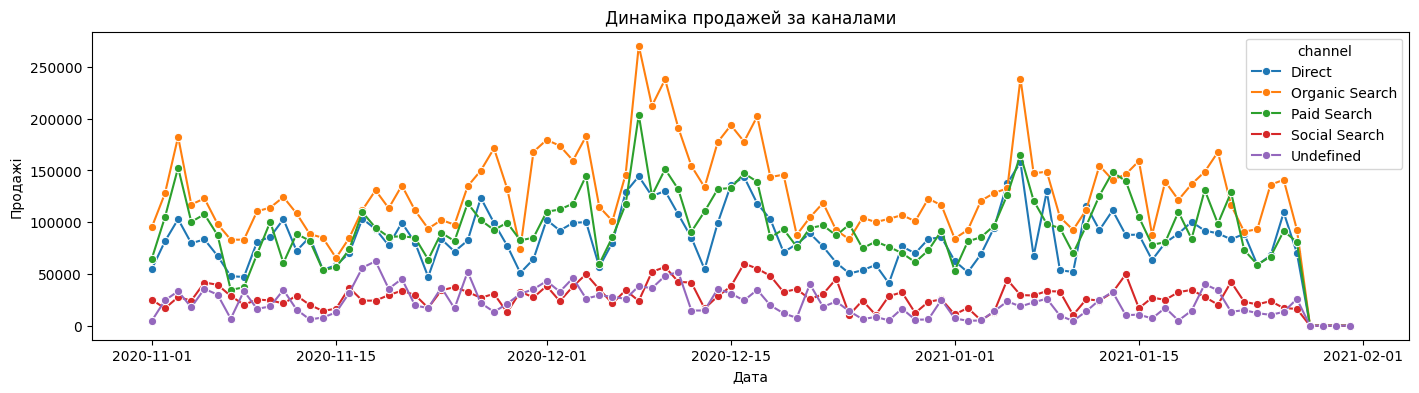

In [ ]:
plt.figure(figsize=(17, 4))
sns.lineplot(data=sales_data_channel, x='date', y='price', hue='channel', marker='o')
plt.title('Динаміка продажей за каналами')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.show()

По Organic Search, Paid Search ріст на початку місяця, Direct є трохи коливання, Social Search більш монотонний

##Динаміка продажей за пристроєм

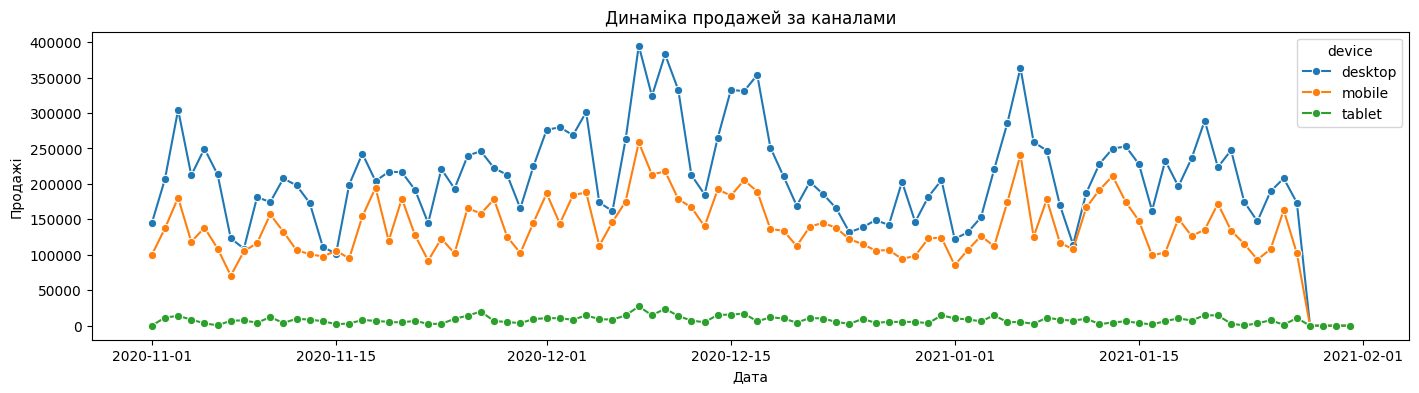

In [ ]:
plt.figure(figsize=(17, 4))
sns.lineplot(data=sales_data_device, x='date', y='price', hue='device', marker='o')
plt.title('Динаміка продажей за каналами')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.show()

По desktop найбльіші продажі (хаотичні), tablet найменші та більш монотонні, mobile теж зберігається невелика хаотичність

#6

In [ ]:
#зведена таблиця, яка показує кількість сесій у розрізі каналів трафіку та типів девайсів
pivot_channel_device = df.pivot_table(index='channel', columns='device', values='ga_session_id', aggfunc='count')
pivot_channel_device

device,desktop,mobile,tablet
channel,,,
Direct,47825,31745,1812
Organic Search,72622,49014,2789
Paid Search,55167,37034,2140
Social Search,16288,10988,638
Undefined,12527,8486,470


In [ ]:
#Зведена таблиця, яка показує загальні продажі за категоріями товарів (топ-10 категорій) у різних країнах (топ-5 країн)
filtered_df_categories = df[df['category'].isin(top_category_sales['category'])]
filtered_df_countries = filtered_df_categories[filtered_df_categories['country'].isin(top_country_sales['country'])]
pivot_category_country = filtered_df_countries.pivot_table(index='country', columns='category', values='price', aggfunc='sum')
pivot_category_country

category,Bar furniture,Beds,Bookcases & shelving units,Cabinets & cupboards,Chairs,Chests of drawers & drawer units,Children's furniture,Outdoor furniture,Sofas & armchairs,Tables & desks
country,,,,,,,,,,
Canada,51724.0,354772.0,278981.9,181802.0,417740.8,71952.0,30264.0,185322.8,692427.5,132678.0
France,11199.0,116414.0,73830.0,59101.5,134029.4,21544.5,14258.0,40486.4,187735.0,42299.0
India,57657.0,358319.5,364507.4,191888.0,544309.2,73111.0,39177.0,162289.4,788430.0,186157.5
United Kingdom,22103.0,133816.0,113987.6,71684.5,188519.4,36784.0,13348.0,57002.4,234812.0,49374.0
United States,330805.0,2213058.0,1567606.9,994545.5,2619773.8,382388.0,207575.0,929245.2,3707144.5,777865.0


In [ ]:
#Зведена таблиця, яка показує продажі за операційною системою та браузером
pivot_tabel_os_browser = df.pivot_table(index='operating_system', columns='browser', values='price', aggfunc='sum')
pivot_tabel_os_browser

browser,<Other>,Android Webview,Chrome,Edge,Firefox,Safari
operating_system,,,,,,
<Other>,5814.0,NaN,800354.3,0.0,16387.5,0.0
Android,216152.4,95717.0,2463259.7,NaN,14856.0,NaN
Macintosh,9879.2,NaN,1785426.3,10915.0,48816.0,649930.8
Web,538694.2,315297.4,13132192.7,468623.4,344999.8,3646097.0
Windows,132477.0,NaN,3293141.8,236905.9,142464.3,0.0
iOS,20338.0,NaN,352475.2,NaN,NaN,3230516.2


In [ ]:
#Зведена таблиця, яка показує продажі за континентом та товаром
pivot_tabel_continent_category = df.pivot_table(index='continent', columns='mobile_model_name', values='price', aggfunc='sum')
pivot_tabel_continent_category

mobile_model_name,<Other>,Chrome,ChromeBook,Edge,Firefox,Pixel 3,Pixel 4 XL,Safari,iPad,iPhone
continent,,,,,,,,,,
(not set),10469.0,20597.4,4411.0,2902.0,25.0,0.0,NaN,22103.0,70.0,13490.0
Africa,75228.5,62929.2,24142.0,9194.0,4491.0,0.0,0.0,91037.0,2071.0,62138.3
Americas,3630042.4,5044340.6,1021732.6,396370.5,239354.6,51989.7,72669.5,3523966.8,250383.7,3434429.6
Asia,1642129.8,2018772.0,406340.9,148902.4,98748.8,29841.0,28982.2,1554347.5,100660.0,1572573.7
Europe,1117926.1,1653279.5,351187.7,136382.4,71687.5,18533.5,16636.0,1186219.8,89689.5,1293082.2
Oceania,59535.0,99605.2,22644.5,3471.0,6760.0,8784.0,0.0,113388.0,5980.0,45062.5


#7

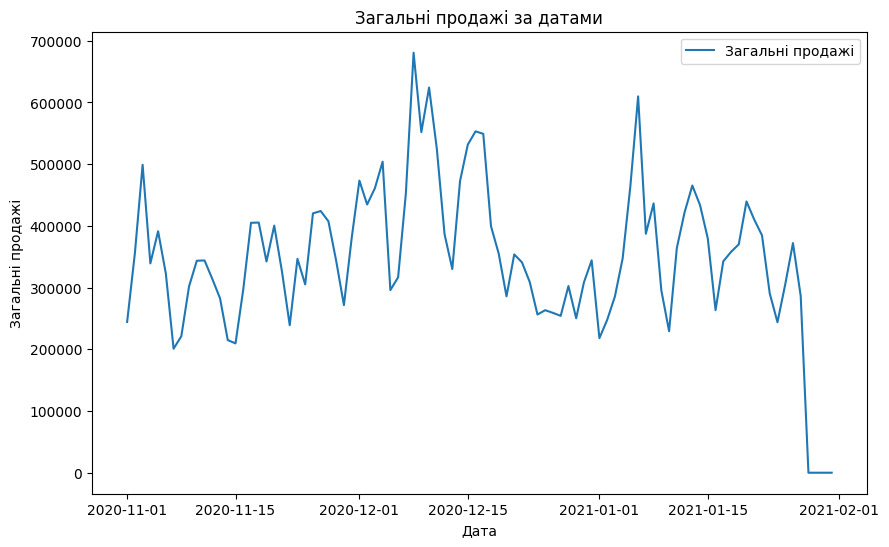

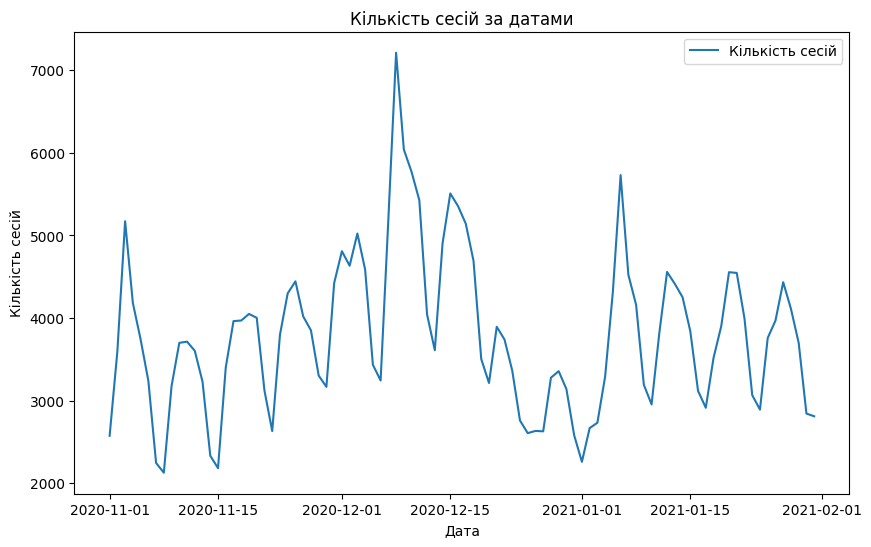

In [ ]:
#кількість сесій та загальні продажі за кожну дату
import matplotlib.pyplot as plt
date_sales_session = df.groupby('date').agg({'price': 'sum', 'ga_session_id': 'count'}).reset_index()
plt.figure(figsize=(10, 6))
plt.plot(date_sales_session['date'], date_sales_session['price'], label='Загальні продажі')
plt.xlabel('Дата')
plt.ylabel('Загальні продажі')
plt.title('Загальні продажі за датами')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(date_sales_session['date'], date_sales_session['ga_session_id'], label='Кількість сесій')
plt.xlabel('Дата')
plt.ylabel('Кількість сесій')
plt.title('Кількість сесій за датами')
plt.legend()
plt.show()

In [ ]:
from scipy.stats import kendalltau
kendall_corr = date_sales_session["ga_session_id"].corr(date_sales_session["price"], method="kendall")
print(kendalltau(date_sales_session['ga_session_id'], date_sales_session['price']))
print(kendall_corr)

SignificanceResult(statistic=0.717666930923723, pvalue=4.2515191569599826e-24)
0.717666930923723


pvalue 4.2515191569599826e-24<0.05 і наш результат є статистично значущим, кореляція 0.717666930923723, що показує достатньо сильний зв'язок.Результати свідчать про існування сильної та статистично значущої кореляції між досліджуваними змінними

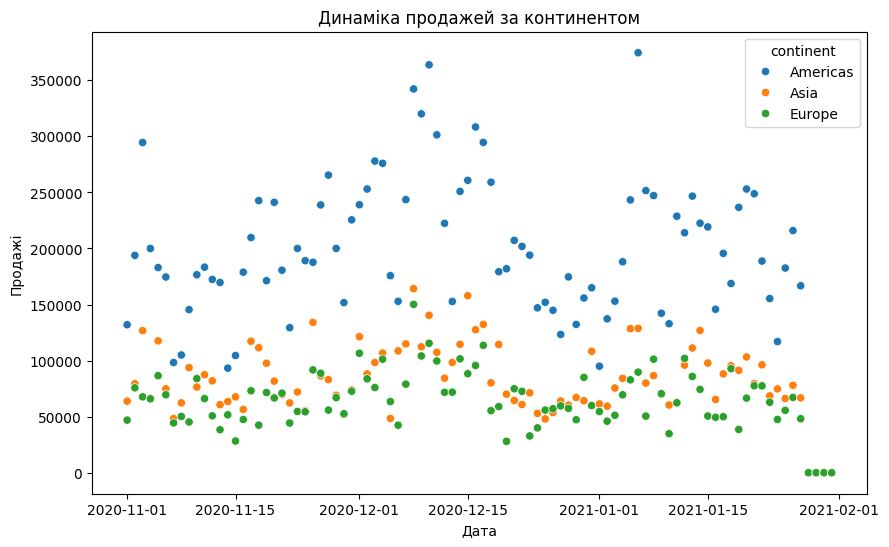

In [ ]:
#Чи корелюють між собою продажі на різних континентах?
sales_date_cont_top = sales_date_of_continent[sales_date_of_continent['continent'].isin(top_continent_sales["continent"])].reset_index(drop=True)
plt.figure(figsize=(10, 6))
sns.scatterplot(x="date", y="price", data=sales_date_cont_top, hue="continent")
plt.xlabel("Дата")
plt.ylabel("Продажі")
plt.title("Динаміка продажей за континентом")
plt.show()

In [ ]:
sales_date_cont_top_americ = sales_date_cont_top[sales_date_cont_top["continent"] == "Americas"].reset_index()
sales_date_cont_top_europe = sales_date_cont_top[sales_date_cont_top["continent"] == "Europe"].reset_index()
sales_date_cont_top_asia = sales_date_cont_top[sales_date_cont_top["continent"] == "Asia"].reset_index()
kendall_corr_cont_americ_europe = sales_date_cont_top_americ["price"].corr(sales_date_cont_top_europe["price"], method="kendall")
kendall_corr_cont_europe_asia = sales_date_cont_top_europe["price"].corr(sales_date_cont_top_asia["price"], method="kendall")
kendall_corr_cont_americ_asia = sales_date_cont_top_americ["price"].corr(sales_date_cont_top_asia["price"], method="kendall")
print(f" Статистична значущість між Америкою та Європою: {kendalltau(sales_date_cont_top_americ['price'], sales_date_cont_top_europe['price'])}")
print(f" Статистична значущість між Європою та Азією: {kendalltau(sales_date_cont_top_europe['price'], sales_date_cont_top_asia['price'])}")
print(f" Статистична значущість між Америкою та Азією: {kendalltau(sales_date_cont_top_americ['price'], sales_date_cont_top_asia['price'])}")
print(f"Кореляція між Америкою та Європою: {kendall_corr_cont_americ_europe}")
print(f"Кореляція між Європою та Азією: {kendall_corr_cont_europe_asia}")
print(f"Кореляція між Америкою та Азією: {kendall_corr_cont_americ_asia}")

 Статистична значущість між Америкою та Європою: SignificanceResult(statistic=0.4985645933014354, pvalue=2.071110421868149e-12)
 Статистична значущість між Європою та Азією: SignificanceResult(statistic=0.48086124401913877, pvalue=1.2017712788503667e-11)
 Статистична значущість між Америкою та Азією: SignificanceResult(statistic=0.517224880382775, pvalue=3.0377068315356127e-13)
Кореляція між Америкою та Європою: 0.4985645933014354
Кореляція між Європою та Азією: 0.48086124401913877
Кореляція між Америкою та Азією: 0.517224880382775


Можемо спостегрігати статистичну значущість майже між всіма континентами (Америка, Азія та Європа), при цьому зв'язок між ними в районі 0.4-0.5 і це свідчить про те, що існує помірний, але статистично значущий зв'язок між цінами на трьох континентах.

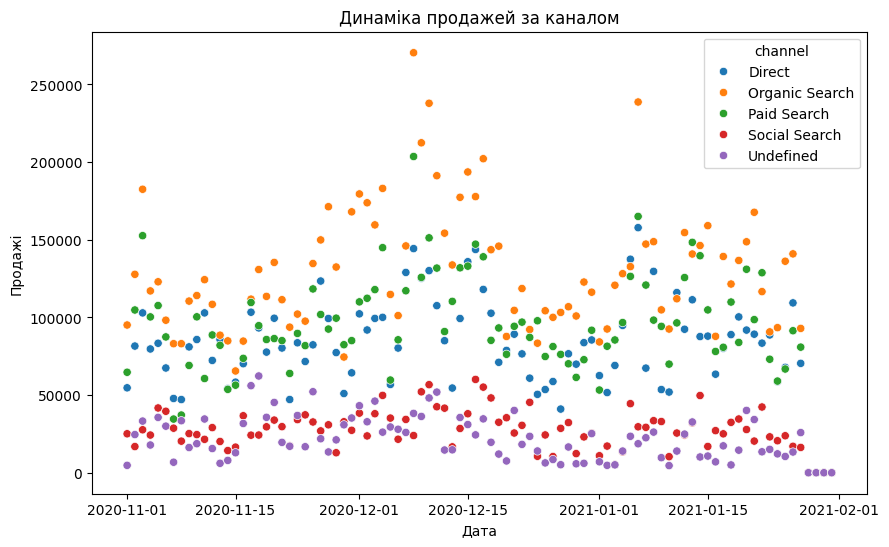

In [ ]:
#Чи корелюють між собою продажі за різними каналами трафіку?
plt.figure(figsize=(10, 6))
sns.scatterplot(x="date", y="price", data=sales_data_channel, hue="channel")
plt.xlabel("Дата")
plt.ylabel("Продажі")
plt.title("Динаміка продажей за каналом")
plt.show()

In [ ]:
sales_date_channel_direct = sales_data_channel[sales_data_channel["channel"] == "Direct"].reset_index()
sales_date_channel_organic = sales_data_channel[sales_data_channel["channel"] == "Organic Search"].reset_index()
sales_date_channel_paid = sales_data_channel[sales_data_channel["channel"] == "Paid Search"].reset_index()
sales_date_channel_social = sales_data_channel[sales_data_channel["channel"] == "Social Search"].reset_index()
sales_date_channel_undef = sales_data_channel[sales_data_channel["channel"] == "Undefined"].reset_index()
kendall_corr_cont_direct_organic = sales_date_channel_direct["price"].corr(sales_date_channel_organic["price"], method="kendall")
kendall_corr_cont_direct_paid = sales_date_channel_direct["price"].corr(sales_date_channel_paid["price"], method="kendall")
kendall_corr_cont_direct_social = sales_date_channel_direct["price"].corr(sales_date_channel_social["price"], method="kendall")
kendall_corr_cont_direct_undef = sales_date_channel_direct["price"].corr(sales_date_channel_undef["price"], method="kendall")
kendall_corr_cont_organic_paid = sales_date_channel_organic["price"].corr(sales_date_channel_paid["price"], method="kendall")
kendall_corr_cont_organic_social = sales_date_channel_organic["price"].corr(sales_date_channel_social["price"], method="kendall")
kendall_corr_cont_organic_undef = sales_date_channel_organic["price"].corr(sales_date_channel_undef["price"], method="kendall")
kendall_corr_cont_paid_social = sales_date_channel_paid["price"].corr(sales_date_channel_social["price"], method="kendall")
kendall_corr_cont_paid_undef = sales_date_channel_paid["price"].corr(sales_date_channel_undef["price"], method="kendall")
kendall_corr_cont_social_undef = sales_date_channel_social["price"].corr(sales_date_channel_undef["price"], method="kendall")
print(f"Статистична значущість між Direct та Organic Search: {kendalltau(sales_date_channel_direct['price'], sales_date_channel_organic['price'])}")
print(f"Статистична значущість між Direct та Paid Search: {kendalltau(sales_date_channel_direct['price'], sales_date_channel_paid['price'])}")
print(f"Статистична значущість між Direct та Socail Search: {kendalltau(sales_date_channel_direct['price'], sales_date_channel_social['price'])}")
print(f"Статистична значущість між Direct та Undefined: {kendalltau(sales_date_channel_direct['price'], sales_date_channel_undef['price'])}")
print(f"Статистична значущість між Organic Search та Paid Search: {kendalltau(sales_date_channel_organic['price'], sales_date_channel_paid['price'])}")
print(f"Статистична значущість між Organic Search та Social Search: {kendalltau(sales_date_channel_organic['price'], sales_date_channel_social['price'])}")
print(f"Статистична значущість між Organic Search та Undefined: {kendalltau(sales_date_channel_organic['price'], sales_date_channel_undef['price'])}")
print(f"Статистична значущість між Paid Search та Social Search: {kendalltau(sales_date_channel_paid['price'], sales_date_channel_social['price'])}")
print(f"Статистична значущість між Paid Search та Undefined: {kendalltau(sales_date_channel_paid['price'], sales_date_channel_undef['price'])}")
print(f"Статистична значущість між Social Search та Undefined: {kendalltau(sales_date_channel_social['price'], sales_date_channel_undef['price'])}")
print(f"Кореляція між: \n Direct та Organic Search: {kendall_corr_cont_direct_organic} \n Direct та Paid Search: {kendall_corr_cont_direct_paid} \n Direct та Social Search: {kendall_corr_cont_direct_social} \n Direct та Undefined: {kendall_corr_cont_direct_undef}")
print(f" Organic Search та Paid Search: {kendall_corr_cont_organic_paid} \n Organic Search та Social Search: {kendall_corr_cont_organic_social} \n Organic Search та Undefined: {kendall_corr_cont_organic_undef}")
print(f" Paid Search та Social Search: {kendall_corr_cont_paid_social} \n Paid Search та Undefined: {kendall_corr_cont_paid_undef} \n Social Search та Undefined: {kendall_corr_cont_social_undef}")

Статистична значущість між Direct та Organic Search: SignificanceResult(statistic=0.5966507177033492, pvalue=4.01037243362041e-17)
Статистична значущість між Direct та Paid Search: SignificanceResult(statistic=0.5531100478468899, pvalue=6.255567261464013e-15)
Статистична значущість між Direct та Socail Search: SignificanceResult(statistic=0.33636363636363636, pvalue=2.109657207955024e-06)
Статистична значущість між Direct та Undefined: SignificanceResult(statistic=0.38851674641148326, pvalue=4.30235629120307e-08)
Статистична значущість між Organic Search та Paid Search: SignificanceResult(statistic=0.609090909090909, pvalue=8.849773040955019e-18)
Статистична значущість між Organic Search та Social Search: SignificanceResult(statistic=0.3282296650717703, pvalue=3.693222634293919e-06)
Статистична значущість між Organic Search та Undefined: SignificanceResult(statistic=0.3698564593301435, pvalue=1.8395163003929308e-07)
Статистична значущість між Paid Search та Social Search: SignificanceR

### Високі кореляції
1. Direct і Organic Search
2. Organic Search і Paid Search
###Помірні кореляції
1. Direct та Paid Search
2. Direct та Undefined
3. Paid Search та Undefined
4. Organic Search та Undefined
###Низькі кореляції
1. Direct та Social Search
2. Organic Search та Social Search
3. Paid Search та Social Search
4. Social Search та Undefined

Усі p-значення дуже малі (менше 0.05), що вказує на високу статистичну значущість.

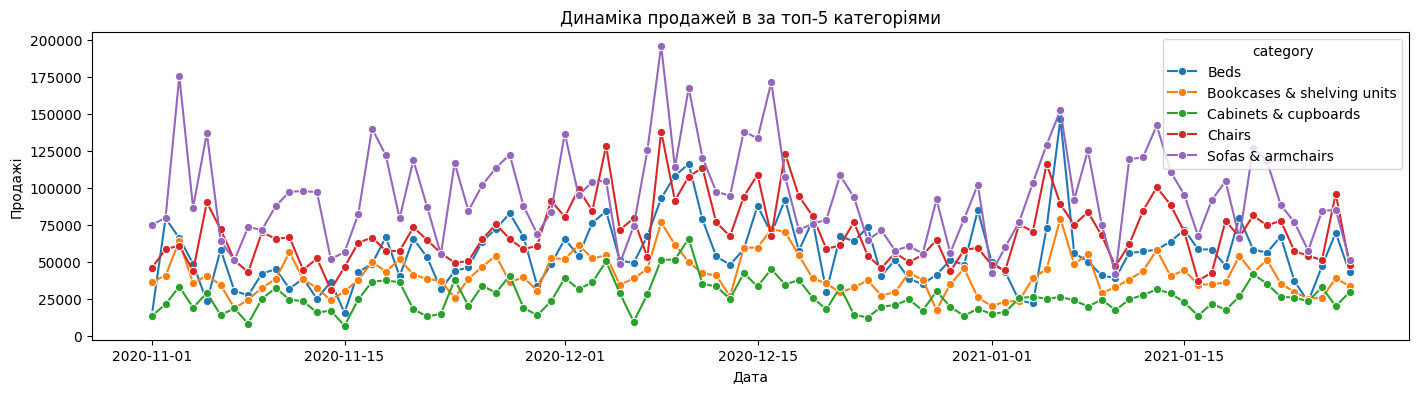

In [ ]:
#Чи корелюють між собою продажі за топ-5 категоріями?
sales_date_categ_top = sales_date_category[sales_date_category['category'].isin(top_category_sales["category"].head(5))].reset_index(drop=True)
plt.figure(figsize=(17, 4))
sns.lineplot(data=sales_date_categ_top, x='date', y='price', hue='category', marker='o')
plt.title('Динаміка продажей в за топ-5 категоріями')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.show()

In [ ]:
sales_date_categ_beds = sales_date_categ_top[sales_date_categ_top["category"] == "Beds"].reset_index()
sales_date_categ_bookscases = sales_date_categ_top[sales_date_categ_top["category"] == "Bookcases & shelving units"].reset_index()
sales_date_categ_cabinets = sales_date_categ_top[sales_date_categ_top["category"] == "Cabinets & cupboards"].reset_index()
sales_date_categ_chairs = sales_date_categ_top[sales_date_categ_top["category"] == "Chairs"].reset_index()
sales_date_categ_sofas = sales_date_categ_top[sales_date_categ_top["category"] == "Sofas & armchairs"].reset_index()
kendall_corr_cont_beds_bookscases = sales_date_categ_beds["price"].corr(sales_date_categ_bookscases["price"], method="kendall")
kendall_corr_cont_beds_cabinets = sales_date_categ_beds["price"].corr(sales_date_categ_cabinets["price"], method="kendall")
kendall_corr_cont_beds_chairs = sales_date_categ_beds["price"].corr(sales_date_categ_chairs["price"], method="kendall")
kendall_corr_cont_beds_sofas = sales_date_categ_beds["price"].corr(sales_date_categ_sofas["price"], method="kendall")
kendall_corr_cont_bookscases_cabinets = sales_date_categ_bookscases["price"].corr(sales_date_categ_cabinets["price"], method="kendall")
kendall_corr_cont_bookscases_chairs = sales_date_categ_bookscases["price"].corr(sales_date_categ_chairs["price"], method="kendall")
kendall_corr_cont_bookscases_sofas = sales_date_categ_bookscases["price"].corr(sales_date_categ_sofas["price"], method="kendall")
kendall_corr_cont_cabinets_chairs = sales_date_categ_cabinets["price"].corr(sales_date_categ_chairs["price"], method="kendall")
kendall_corr_cont_cabinets_sofas = sales_date_categ_cabinets["price"].corr(sales_date_categ_sofas["price"], method="kendall")
kendall_corr_cont_chairs_sofas = sales_date_categ_chairs["price"].corr(sales_date_categ_sofas["price"], method="kendall")
print(f"Статистична значущість між \n Beds та Bookcases & shelving units: {kendalltau(sales_date_categ_beds['price'], sales_date_categ_bookscases['price'])}")
print(f" Beds та Cabinets & cupboards: {kendalltau(sales_date_categ_beds['price'], sales_date_categ_cabinets['price'])}")
print(f" Beds та Chairs: {kendalltau(sales_date_categ_beds['price'], sales_date_categ_chairs['price'])}")
print(f" Beds та Sofas & armchairs: {kendalltau(sales_date_categ_beds['price'], sales_date_categ_sofas['price'])}")
print(f" Bookcases & shelving units та Cabinets & cupboards: {kendalltau(sales_date_categ_bookscases['price'], sales_date_categ_cabinets['price'])}")
print(f" Bookcases & shelving units та Chairs: {kendalltau(sales_date_categ_bookscases['price'], sales_date_categ_chairs['price'])}")
print(f" Bookcases & shelving units та Sofas & armchairs: {kendalltau(sales_date_categ_bookscases['price'], sales_date_categ_sofas['price'])}")
print(f" Cabinets & cupboards та Chairs: {kendalltau(sales_date_categ_cabinets['price'], sales_date_categ_chairs['price'])}")
print(f" Cabinets & cupboards та Sofas & armchairs: {kendalltau(sales_date_categ_cabinets['price'], sales_date_categ_sofas['price'])}")
print(f" Chairs та Sofas & armchairs: {kendalltau(sales_date_categ_chairs['price'], sales_date_categ_sofas['price'])}")
print(f"Кореляція між:\n Beds та Bookcases & shelving units: {kendall_corr_cont_beds_bookscases}")
print(f" Beds та Cabinets & cupboards: {kendall_corr_cont_beds_cabinets}")
print(f" Beds та Chairs: {kendall_corr_cont_beds_chairs}")
print(f" Beds та Sofas & armchairs: {kendall_corr_cont_beds_sofas}")
print(f" Bookcases & shelving units та Cabinets & cupboards: {kendall_corr_cont_bookscases_cabinets}")
print(f" Bookcases & shelving units та Chairs: {kendall_corr_cont_bookscases_chairs}")
print(f" Bookcases & shelving units та Sofas & armchairs: {kendall_corr_cont_bookscases_sofas}")
print(f" Cabinets & cupboards та Chairs: {kendall_corr_cont_cabinets_chairs}")
print(f" Cabinets & cupboards та Sofas & armchairs: {kendall_corr_cont_cabinets_sofas}")
print(f" Chairs та Sofas & armchairs: {kendall_corr_cont_chairs_sofas}")

Статистична значущість між 
 Beds та Bookcases & shelving units: SignificanceResult(statistic=0.384012539184953, pvalue=1.1706714811507441e-07)
 Beds та Cabinets & cupboards: SignificanceResult(statistic=0.30982236154649945, pvalue=1.9160588460808808e-05)
 Beds та Chairs: SignificanceResult(statistic=0.3709508881922675, pvalue=3.0910011012746804e-07)
 Beds та Sofas & armchairs: SignificanceResult(statistic=0.3662486938349008, pvalue=4.3506391431381156e-07)
 Bookcases & shelving units та Cabinets & cupboards: SignificanceResult(statistic=0.3657262277951933, pvalue=4.5179218901849126e-07)
 Bookcases & shelving units та Chairs: SignificanceResult(statistic=0.45611285266457685, pvalue=3.1189731830360263e-10)
 Bookcases & shelving units та Sofas & armchairs: SignificanceResult(statistic=0.4472309299895507, pvalue=6.820046908233478e-10)
 Cabinets & cupboards та Chairs: SignificanceResult(statistic=0.3672936259143156, pvalue=4.0338173592571087e-07)
 Cabinets & cupboards та Sofas & armchairs: 

###Помірні кореляції
1. Beds та інші категорії
2. Bookcases & shelving units та інші категорії
3. Cabinets & cupboards та інші категорії
4. Chairs та Sofas & armchairs

Усі p-значення дуже малі, що вказує на високу статистичну значущість, свідчить про існування помірних, але статистично значущих взаємозв'язків між різними категоріями меблів.

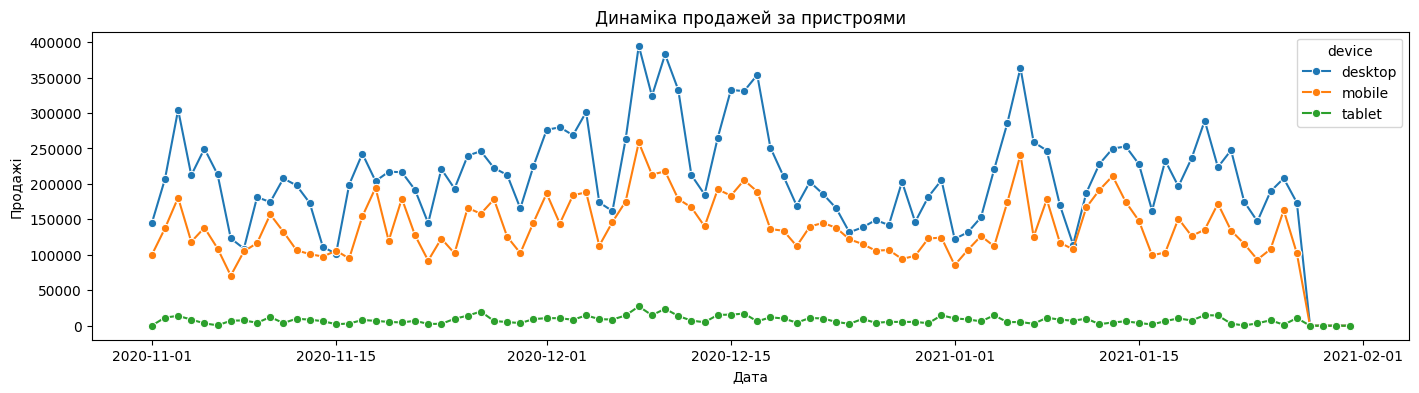

In [ ]:
#Чи корелюють між собою продажі за різними пристроями?
plt.figure(figsize=(17, 4))
sns.lineplot(data=sales_data_device, x='date', y='price', hue='device', marker='o')
plt.title('Динаміка продажей за пристроями')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.show()

In [ ]:
sales_date_device_mobile = sales_data_device[sales_data_device["device"] == "mobile"].reset_index()
sales_date_device_tablet = sales_data_device[sales_data_device["device"] == "tablet"].reset_index()
sales_date_device_desktop = sales_data_device[sales_data_device["device"] == "desktop"].reset_index()
kendall_corr_dev_mobile_tabl = sales_date_device_mobile["price"].corr(sales_date_device_tablet["price"], method="kendall")
kendall_corr_dev_mobile_desktop = sales_date_device_mobile["price"].corr(sales_date_device_desktop["price"], method="kendall")
kendall_corr_dev_tablet_desktop = sales_date_device_tablet["price"].corr(sales_date_device_desktop["price"], method="kendall")
print(f"Статистична значущість між \n mobile та tablet: {kendalltau(sales_date_device_mobile['price'], sales_date_device_tablet['price'])}")
print(f" mobile та desktop: {kendalltau(sales_date_device_mobile['price'], sales_date_device_desktop['price'])}")
print(f" tablet та desktop: {kendalltau(sales_date_device_tablet['price'], sales_date_device_desktop['price'])}")
print(f"Кореляція між:\n mobile та tablet: {kendall_corr_dev_mobile_tabl}")
print(f" mobile та desktop: {kendall_corr_dev_mobile_desktop}")
print(f" tablet та desktop: {kendall_corr_dev_tablet_desktop}")

Статистична значущість між 
 mobile та tablet: SignificanceResult(statistic=0.3457351382558216, pvalue=1.0924710285419303e-06)
 mobile та desktop: SignificanceResult(statistic=0.6124401913875598, pvalue=5.861311039677274e-18)
 tablet та desktop: SignificanceResult(statistic=0.33568608925461435, pvalue=2.2173491013027885e-06)
Кореляція між:
 mobile та tablet: 0.3457351382558216
 mobile та desktop: 0.6124401913875598
 tablet та desktop: 0.33568608925461435


###Високі кореляції
1. Mobile та Desktop
###Помірні кореляції
1. Mobile та Tablet
2. Tablet та Desktop
###Усі p-значення дуже малі, що вказує на високу статистичну значущість.

#8

##Проаналізуй продажі за кожну дату зареєстрованих та незареєстрованих користувачів.

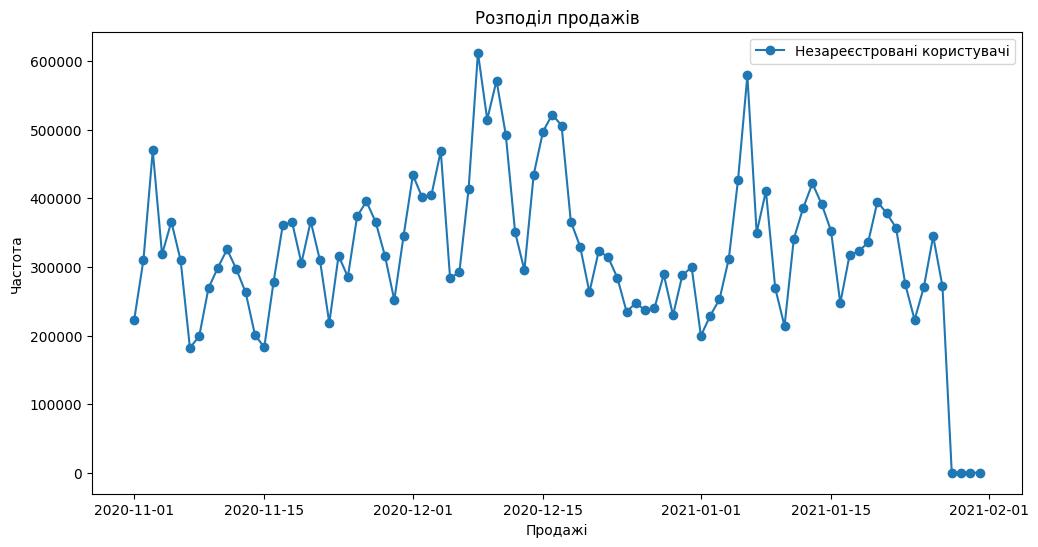

In [ ]:
from scipy.stats import shapiro, mannwhitneyu, normaltest
#Покажемо динаміку для зареєстрованих та незареєстрованих користувачів
registered_sales = df[df['id'].notnull()][['price', "date"]]
unregistered_sales = df[df['id'].isnull()][['price', "date"]]
registered_sales_by_date = registered_sales.groupby('date')['price'].sum().reset_index()
unregistered_sales_by_date = unregistered_sales.groupby('date')['price'].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(unregistered_sales_by_date['date'], unregistered_sales_by_date['price'], label='Незареєстровані користувачі', marker='o')
plt.legend(loc='upper right')
plt.title('Розподіл продажів')
plt.xlabel('Продажі')
plt.ylabel('Частота')
plt.show()

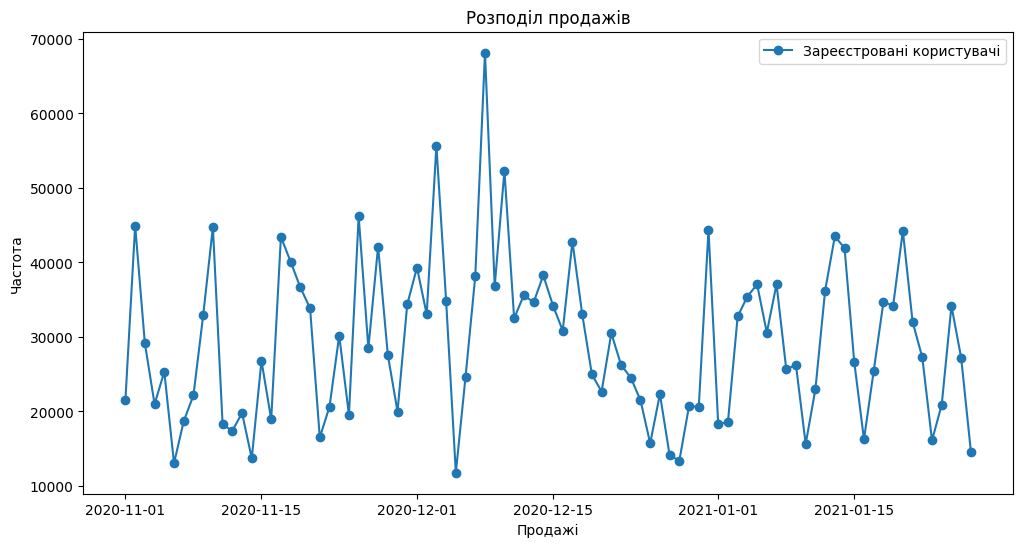

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(registered_sales_by_date['date'], registered_sales_by_date['price'], label='Зареєстровані користувачі', marker='o')
plt.legend(loc='upper right')
plt.title('Розподіл продажів')
plt.xlabel('Продажі')
plt.ylabel('Частота')
plt.show()

Як бачимо з візуалізації, розподіли не є нормальними (симетричні з правим хвостом), але перевіримо це за допомогою теста

In [ ]:
stat_reg, p_reg = shapiro(registered_sales_by_date["price"])
stat_unreg, p_unreg = shapiro(unregistered_sales_by_date["price"])
for p_value in [p_reg, p_unreg]:
  if p_value > 0.05:
    print("Розподіл є нормальним")
  else:
    print("Розподіл не є нормальним")

Розподіл не є нормальним
Розподіл не є нормальним


Ось і бачимо підтвердження, що наші розподіли не є нормальними

In [ ]:
stat_u, p_u = mannwhitneyu(
    registered_sales['price'],
    unregistered_sales['price']
)
if p_u < 0.05:
    print("Між групами є статистично значущі відмінності (тест Манна-Уітні).")
else:
    print("Статистично значущих відмінностей немає.")

Статистично значущих відмінностей немає.


##Проаналізуй кількість сесій за різними каналами трафіку.

In [ ]:
df_group_channel = df.groupby('channel')['ga_session_id'].count().reset_index()
_, p = shapiro(df_group_channel['ga_session_id'])
if p > 0.05:
  print("Розподіл є нормальним")
else:
  print("Розподіл не є нормальним")
df_group_channel["channel"].unique()

Розподіл є нормальним


array(['Direct', 'Organic Search', 'Paid Search', 'Social Search',
       'Undefined'], dtype=object)

Розподіл є нормальним, тому для перевірки статистичної значущості використовуємо ANOVA

In [ ]:
from scipy.stats import f_oneway
f_stat, p_value = f_oneway(df['ga_session_id'][df['channel'] == 'Direct'], df['ga_session_id'][df['channel'] == 'Organic Search'], df['ga_session_id'][df['channel'] == 'Paid Search'], df['ga_session_id'][df['channel'] == 'Social Search'], df['ga_session_id'][df['channel'] == 'Undefined'])
if p_value < 0.05:
  print("Між групами є статистично значущі відмінності")
else:
  print("Статистично значущих відмінностей немає")


Статистично значущих відмінностей немає


##Чи відрізняється статистично доля сесій з органічним трафіком у Європі та Америці?

In [ ]:
#Виведемо сесії з відповідним каналом на континентом
from scipy.stats import normaltest
df_eu_am = df[((df["continent"] == "Americas") | (df["continent"] == "Europe")) & (df["medium"] == "organic")]
df_eu = df_eu_am[df_eu_am["continent"] == "Europe"]["ga_session_id"].reset_index(drop=True)
df_am = df_eu_am[df_eu_am["continent"] == "Americas"]["ga_session_id"].reset_index(drop=True)
stat_reg, p_eu = normaltest(df_eu_am["ga_session_id"])
if p_eu < 0.05:
    print("Розподіл не є нормальним")
else:
    print("Розподіл є нормальним")

Розподіл не є нормальним


In [ ]:
u_stat, p_value = mannwhitneyu(df_eu, df_am)

if p_value < 0.05:
    print("Між групами є статистично значущі відмінності")
else:
    print("Статистично значущих відмінностей немає")

Між групами є статистично значущі відмінності


##Проаналізуй продажі користувачів,які підтвердили та непідтвердили свою пошту

In [ ]:
verified_price = df[df['is_verified'] == '1']['price']
no_verified_price = df[df['is_verified'] == '0']['price']
_, p_verified = shapiro(verified_price)
_, p_no_verified = shapiro(no_verified_price)
for p_value in [p_verified, p_no_verified]:
  if p_value > 0.05:
    print("Розподіл є нормальним ")
  else:
    print("Розподіл не є нормальним")

Розподіл не є нормальним
Розподіл не є нормальним


Жодний із розподілів не є нормальним

In [ ]:
u_stat, p_value = mannwhitneyu(verified_price, no_verified_price)
if p_value < 0.05:
  print("Між групами є статистично значущі відмінності")
else:
  print("Статистично значущих відмінностей немає")

Статистично значущих відмінностей немає


In [ ]:
# Connecting Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Changing work folder
%cd /content/drive/MyDrive/PythonforDataAnalytics/

/content/drive/MyDrive/PythonforDataAnalytics


In [ ]:
df.to_csv('output1.txt', sep='\t', index=False, header=True)

#[Dashboard](https://public.tableau.com/app/profile/nataliia.krasilynets/viz/Book1_17362599390800/Sales)